In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
import urllib.parse

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
MONGODB_HOST = pd.read_csv('./database/auth')['host'][0]
username = urllib.parse.quote_plus(pd.read_csv('./database/auth')['username'][0])
password = urllib.parse.quote_plus(pd.read_csv('./database/auth')['password'][0])
conn = MongoClient('mongodb://%s:%s@%s' % (username, password, MONGODB_HOST))

#conn.database_names()

db = conn['KU']
collection_list = db.collection_names()

score_list = [x for x in collection_list if 'QuizScore' in x]
feature_list = [x for x in collection_list if 'feature' in x]
#score_df = pd.DataFrame(list(db[coll_list[2]].find()))['score'].astype(int)

In [4]:
score_list[1]

'Course_792efa2c1b_QuizScore'

In [5]:
feature_list[2]

'Course_792efa2c1b_feature'

In [6]:
datasets = 'KU'
db = conn[datasets]
collection = db[score_list[4]]
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)
score_df = score_df[['userid', 'score']]
score_df = score_df.rename(index=str, columns={"userid": "username"})
score_df.head(5)

,username,score
0,00a4daec75,94.285714
1,0f26021048,87.500000
2,12cbe43d23,75.000000
3,15183f5bd7,90.000000
4,1.55795e+15,90.000000


In [7]:
db = conn[datasets]
collection = db[feature_list[8]]
feature_df = pd.DataFrame(list(collection.find()))

feature_df = feature_df.drop(['_id'], axis=1)
#feature_df = feature_df.drop(['email'], axis=1)
#feature_df = feature_df.drop(['label'], axis=1)
#feature_df = feature_df.drop(['course_id'], axis=1)
feature_df = feature_df.rename(index=str, columns={"Userid": "username"})

#feature_df = feature_df.fillna('0')
feature_df.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,PAGE_JUMP,Prev,REGIST_CONTENTS,Search,username
0,4,425,5,0,9,2,41,1,19,466,6,948,15,19,488,0,0,0c56718360
1,4,187,1,0,3,0,11,0,40,198,1,1495,15,40,998,0,0,ed0062e95e
2,10,165,6,0,6,5,18,0,123,183,6,1568,19,123,966,0,0,3598080427
3,1,108,1,0,8,1,29,0,72,137,1,1495,21,72,778,0,0,1ba8eeb671
4,3,199,0,0,11,3,13,0,69,212,0,1142,21,69,203,0,0,71861b510e


In [8]:
ncu_ets = pd.merge(feature_df, score_df, on='username')
ncu_ets = ncu_ets.drop(['username'], axis=1)
#ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['score'] < 80
ncu_ets = ncu_ets.drop(['score'], axis=1)
ncu_ets.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,PAGE_JUMP,Prev,REGIST_CONTENTS,Search,class
0,4.0,425.0,5.0,0.0,9.0,2.0,41.0,1.0,19.0,466.0,6.0,948.0,15.0,19.0,488.0,0.0,0.0,True
1,4.0,187.0,1.0,0.0,3.0,0.0,11.0,0.0,40.0,198.0,1.0,1495.0,15.0,40.0,998.0,0.0,0.0,False
2,10.0,165.0,6.0,0.0,6.0,5.0,18.0,0.0,123.0,183.0,6.0,1568.0,19.0,123.0,966.0,0.0,0.0,False
3,1.0,108.0,1.0,0.0,8.0,1.0,29.0,0.0,72.0,137.0,1.0,1495.0,21.0,72.0,778.0,0.0,0.0,False
4,3.0,199.0,0.0,0.0,11.0,3.0,13.0,0.0,69.0,212.0,0.0,1142.0,21.0,69.0,203.0,0.0,0.0,True


In [9]:
#x = feature_df.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(X)
#df = pd.DataFrame(x_scaled)

In [10]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

#X = SelectKBest(chi2, k=10).fit_transform(X, y)
#X_new.shape

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5,
                     gamma='scale')

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                         random_state=5,
                         gamma='scale')


In [11]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    print(image_name)
    fig.savefig(image_name, dpi=300)
    
    return aucs

./images/KU_original.png
./images/KU_SMOTE.png
./images/KU_ADASYM.png
./images/KU_ClusterCentroids.png
./images/KU_NearMiss.png


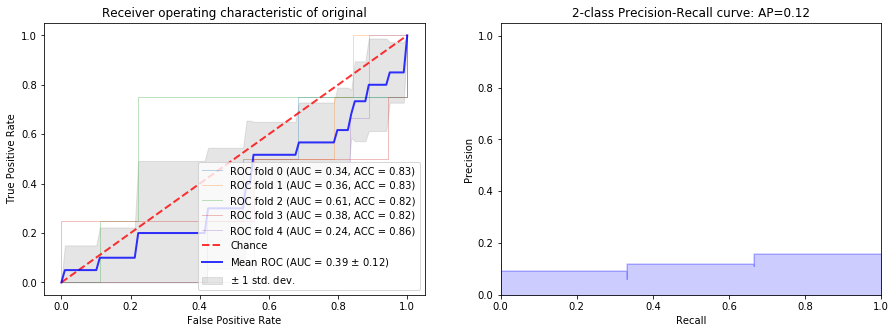

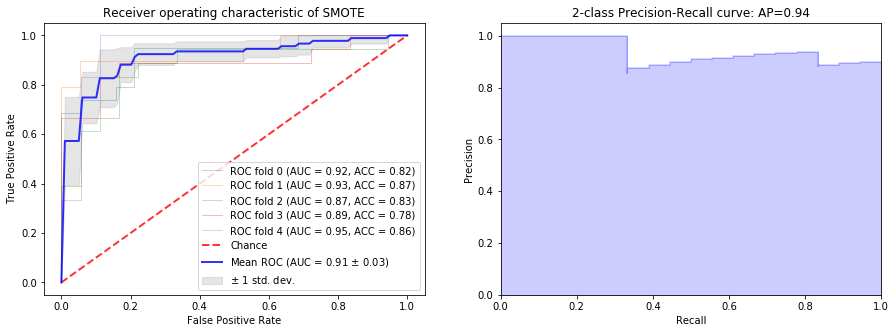

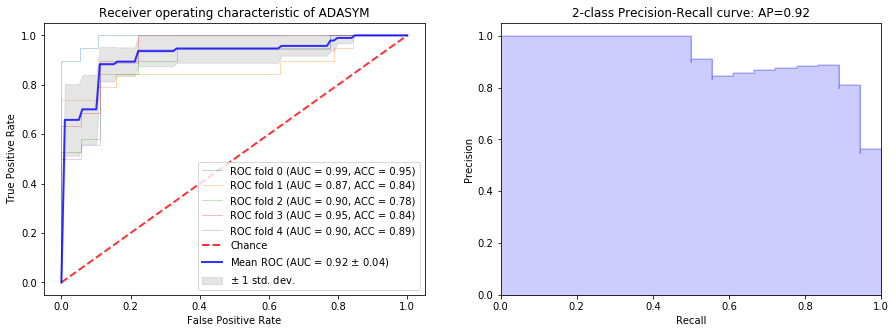

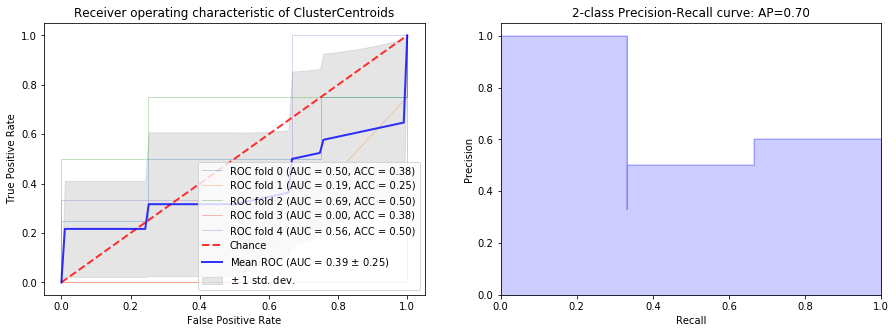

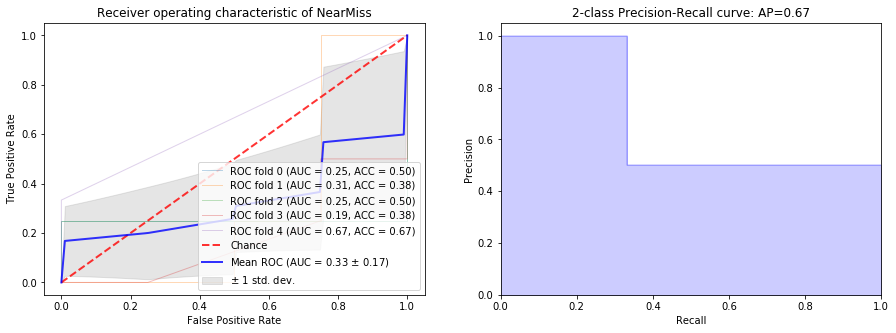

In [12]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')

In [13]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.006092890177672406
two-sample wilcoxon-test 0.006092890177672406
two-sample wilcoxon-test 0.5
two-sample wilcoxon-test 0.2009826791783677


In [14]:
y_pred = clf_binary.fit(X, y).predict_proba(X)

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

In [15]:
temp_pd = ncu_ets
#temp_pd = pd.DataFrame(X)
temp_pd['original'] = y_pred[:, 1].round()
temp_pd['smote'] = y_pred_res[:, 1].round()
#temp_pd['class'] = pd.DataFrame(y)
temp_pd.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,PAGE_JUMP,Prev,REGIST_CONTENTS,Search,class,original,smote
0,4.0,425.0,5.0,0.0,9.0,2.0,41.0,1.0,19.0,466.0,6.0,948.0,15.0,19.0,488.0,0.0,0.0,True,0.0,1.0
1,4.0,187.0,1.0,0.0,3.0,0.0,11.0,0.0,40.0,198.0,1.0,1495.0,15.0,40.0,998.0,0.0,0.0,False,0.0,0.0
2,10.0,165.0,6.0,0.0,6.0,5.0,18.0,0.0,123.0,183.0,6.0,1568.0,19.0,123.0,966.0,0.0,0.0,False,0.0,0.0
3,1.0,108.0,1.0,0.0,8.0,1.0,29.0,0.0,72.0,137.0,1.0,1495.0,21.0,72.0,778.0,0.0,0.0,False,0.0,0.0
4,3.0,199.0,0.0,0.0,11.0,3.0,13.0,0.0,69.0,212.0,0.0,1142.0,21.0,69.0,203.0,0.0,0.0,True,0.0,1.0


In [16]:
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

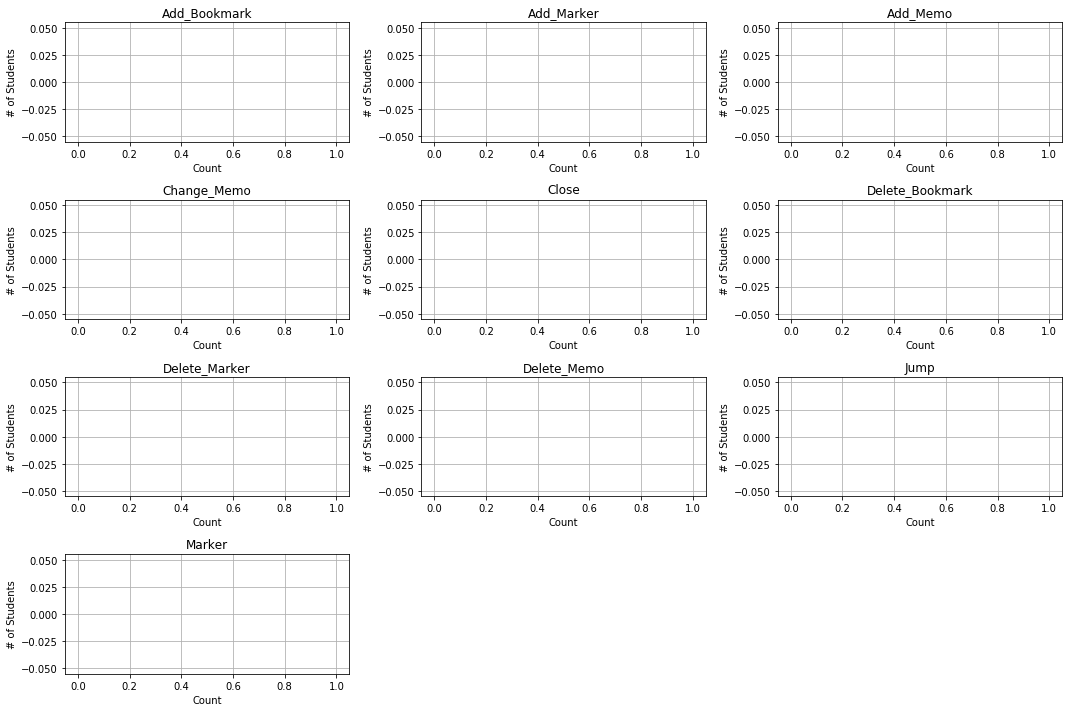

In [17]:
#plt.figure(figsize=(15, 15))
ax = origin_pd[list(origin_pd)[0:10]].hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

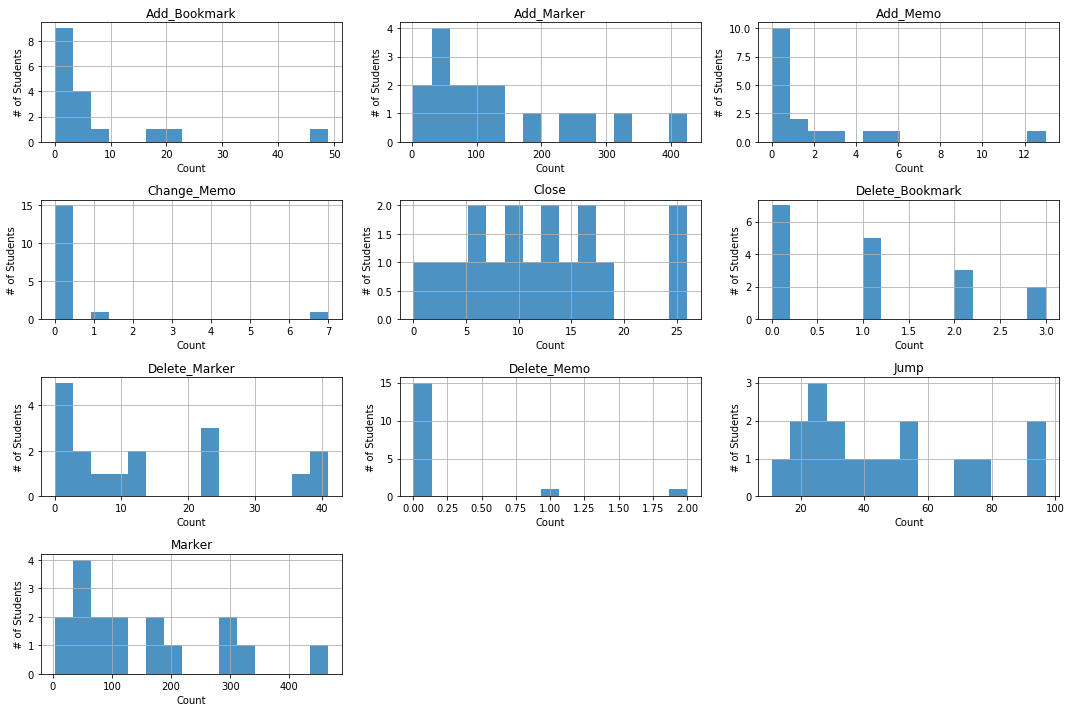

In [18]:
ax = smote_pd[list(smote_pd)[0:10]].hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)

In [19]:
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))



0
17
0
2


In [20]:
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))

90
2
0
0


Type1: risk students been misidenfied (nop)

Type2: risk students been misidenfied, but fixed by resample (good)

Type3: risk students been identified, but misidentified by resample (bad)

Type4: risk students been identified (nop)

Type5: non-risk students been identified (nop)

Type6: non-risk students been identified, but misidentified by resample (bad)

Type7: non-risk students been misidentified, but fixed by resample (good)

Type8: non-risk students been misidentified (nop) {{a}}

IndexError: list index out of range

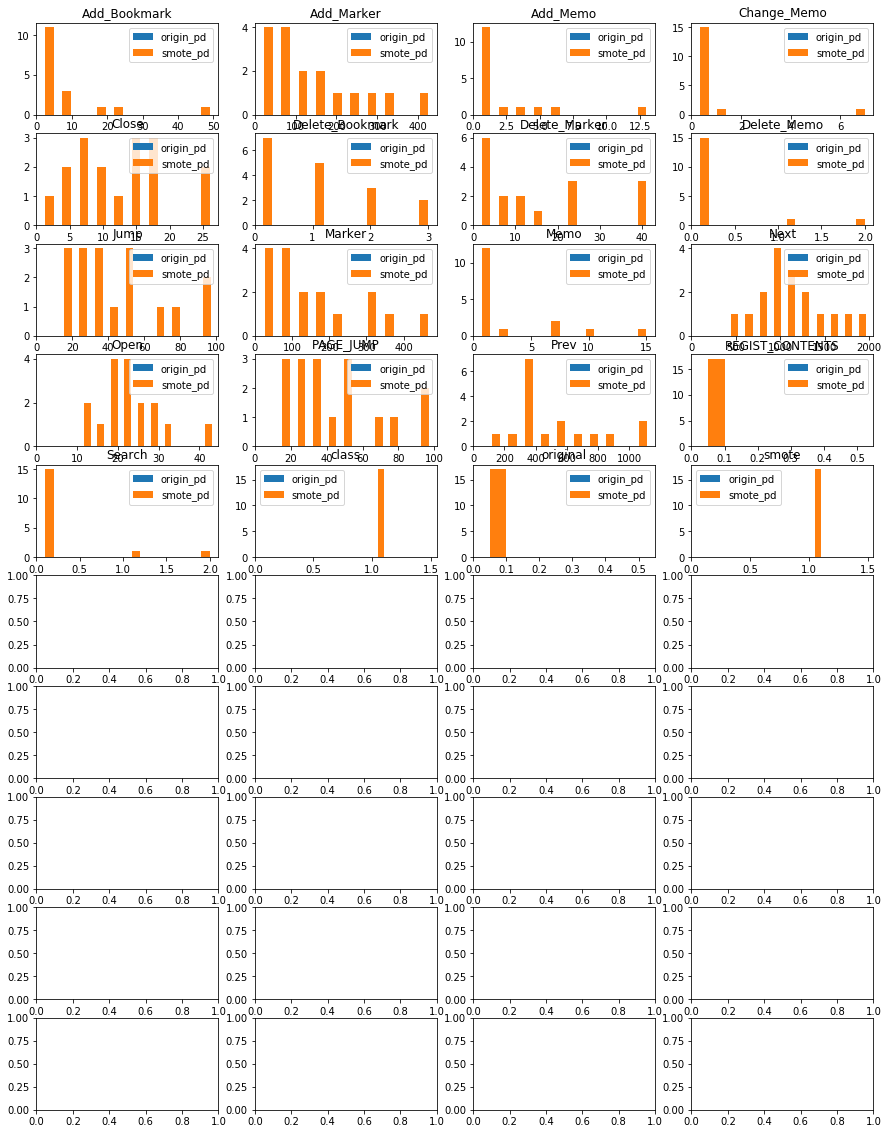

In [21]:
#data=np.random.random((4,10))
#xaxes = ['x1','x2','x3','x4']
#yaxes = ['y1','y2','y3','y4']
titles = list(origin_pd)

fig, axes = plt.subplots(10,4, figsize=(15, 20))
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd[list(origin_pd)[idx]].values, 
            smote_pd[list(smote_pd)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'smote_identified' + '.png'
plt.savefig(image_name, dpi=300)

In [ ]:
origin_pd_t5 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd_t6 = temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

In [ ]:
titles = list(origin_pd)

fig, axes = plt.subplots(10,4, figsize=(15, 20))
bins=10
a = axes.ravel()
for idx,ax in enumerate(a):
    ax.hist([origin_pd_t5[list(origin_pd_t5)[idx]].values,
            smote_pd_t6[list(smote_pd_t6)[idx]].values],
            label=['origin_pd','smote_pd'],
            bins=bins,
            rwidth=10.0)

    ax.legend()
    ax.set_title(titles[idx])
    #ax.set_xlabel(xaxes[idx])
    #ax.set_ylabel(yaxes[idx])
    ax.set_xlim(left=0)
    #plt.legend()

plt.tight_layout()

image_name = './images/' + datasets + '_' + 'smote_misidentified' + '.png'
plt.savefig(image_name, dpi=300)

In [ ]:
plt.rcParams.update({'font.size': 16})


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
bins=10

ax[0].hist([origin_pd[list(origin_pd)[2]].values,
            smote_pd[list(smote_pd)[2]].values],
            label=['Type1:misidentified', 'Type2:misidentified, but \nidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[0].legend()
ax[0].set_xlabel('Number of Activites')
ax[0].set_ylabel('Number of Recoards')
ax[0].set_title('Risk Population')
ax[0].set_xlim(left=0)

ax[1].hist([origin_pd_t5[list(origin_pd_t5)[2]].values,
            smote_pd_t6[list(smote_pd_t6)[2]].values],
            label=['Type5:identified', 'Type6:identified, but \nmisidentified after resample'],
            bins=bins,
            rwidth=10.0)

ax[1].legend()
ax[1].set_xlabel('Number of Activites')
ax[1].set_ylabel('Number of Recoards')
ax[1].set_title('non-Risk Population')
ax[1].set_xlim(left=0)

plt.tight_layout()
image_name = './images/' + datasets + '_' + list(origin_pd)[2] + '.png'
plt.savefig(image_name, dpi=300)

As shown in above figure, we collected activite_sum_count distribution in risk and non-risk population, and we seperate it into two types associate with different colors. The reason we have not plot risk been identified and non-risk student been mis-identified is cause each group have no value. In risk population, the bule color means classification result in type 1, which means classifiers misidentified, however, the orange color means misidentified at the first classifier, but been identified after data reasmple. On the other hand, in non-risk population, the blue color means non-risk population been idenified by the first classifier, and the orange color menas non-risk population been misidenitified after data reample. This result indicated that if students activite_sum_count more than 0, the risk level can be perfect identified after data resample. However, if students activite_sum_count equal to 0, not only first classifer, but also data resample cannot predicted well, in particular change the correct predict to the wrong one. Fortunately, in real classroom, teachers should intevene student population who not only be warned by algorithm, but also low engagement level. 



In [ ]:
plt.rcParams.update({'font.size': 16})

vegetables = ["Identified", 
              "Identified \nafter Resample", 
              "Mis-identified",
              "Mis-identified \nafter Resample"]
farmers = ["Risk", "Non-Risk"]

#risk
T1 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)])
T2 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)])
T3 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)])
T4 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)])
#non-risk
T5 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)])
T6 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)])
T7 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)])
T8 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)])

harvest = np.array([[T4, T5],
                    [T2, T7],
                    [T1, T8],
                    [T3, T6]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 40: 
            color='white'
        else:
            color='black'    
        text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
                       ha="center", va="center", color=color)

#ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("True Label")
ax.set_ylabel("Predict Label")

#plt.colorbar()
#cb.set_label('mean value')
fig.tight_layout()

image_name = './images/' + datasets + '_' + 'c_matrix' + '.png'
plt.savefig(image_name, dpi=300)

plt.show()